In [1]:
#@title Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/sysg3/'
''' If SSL error _ssl.c:997: 
    pip install --upgrade certifi'''

###COOLWARM COLORMAP DOCUMENTATION  
#https://depts.washington.edu/airqual/coolwarm.m
#Base blue: RGB = [59 76 192]
#Base red:  RGB = [180 4 38]
warm_red = [180/255, 4/255, 38/255]
cool_blue = [59/255,76/255,192/255]
mix_purp = np.divide(np.add(warm_red,cool_blue),2).tolist()

tjy_udf:  ['H_find', 'Kap_D', 'git_sync', 'lighten_color', 'plot_anim', 'plot_pha', 'plot_pha_feed', 'ticks']


2.0
sigma_target: 0.2, sigma_calc: 0.2673 (33.65%), R: 1.20
nx (odd): 3, Lx: 3.80
ny (even) : 4, Ly: 6.20
Deltax: 18, Deltay: 10
Nx: 19, Ny: 31
////////
nx_2 (odd): 2.0, Lx_2: 2.00
ny_2 (even) : 2.0, Ly_2: 3.20
Nx_2: 10, Ny_2: 16


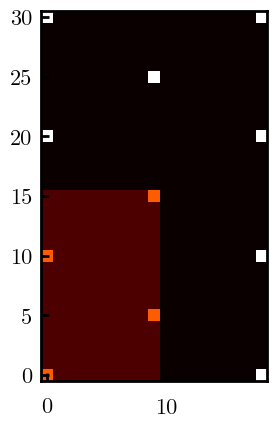

In [8]:
# NBC
import math
sigma = 0.20 # c/nm2
Lx, Ly = 5, 7# nm
dx = 0.20 #nm
dy = dx

R = math.floor( np.sqrt(2/(3*np.sqrt(3)*sigma)) / dx ) * dx
s3R = math.floor( np.sqrt(3)*R / dx ) * dx
Deltax, Deltay = int(3*R/dx), int(s3R/dy)

nx = 2*math.floor(Lx/(3*R))
if (nx%2)==0: nx += 1 # nx must be odd
nx_2 = (nx-1)/2 + 1
Lx   = Deltax*dx*(nx-1)  /2+dx
Lx_2 = Deltax*dx*(nx_2-1)/2+dx

print(s3R)
ny = math.floor(Ly/(s3R))
if (ny%2)==1: ny += 1 # ny must be even
ny_2 = ny/2
Ly   =     Deltay*dy*(ny-1)  +dy
Ly_2 = 1.5*Deltay*dy*(ny_2-1)+dy

Nx   = int(    Deltax*(nx-1)  /2) +1
Ny   = int(    Deltay*(ny-1))     +1
Nx_2 = int(    Deltax*(nx_2-1)/2) +1
Ny_2 = math.floor(1.5*Deltay*(ny_2-1))   +1

s_calc = 2/(3*np.sqrt(3)*R**2)
print("sigma_target: {}, sigma_calc: {:.4f} ({:.2f}%), R: {:.2f}".format(sigma, s_calc, 100*(s_calc/sigma-1.0), R))
print("nx (odd): {}, Lx: {:.2f}".format(nx, Lx))
print("ny (even) : {}, Ly: {:.2f}".format(ny, Ly))
print("Deltax: {}, Deltay: {}".format(Deltax, Deltay))
print("Nx: {}, Ny: {}".format(Nx, Ny))
print("////////")
print("nx_2 (odd): {}, Lx_2: {:.2f}".format(nx_2, Lx_2))
print("ny_2 (even) : {}, Ly_2: {:.2f}".format(ny_2, Ly_2))
print("Nx_2: {}, Ny_2: {}".format(Nx_2, Ny_2))

SURF = np.zeros((Nx, Ny))
s1 = (0, Ly-dy) 
s2 = (math.floor(3*R/2/dx)*dx, math.floor(s3R/2/dy)*dy)

x1, y1 = int(s1[0]/dx), int(s1[1]/dy)
while (x1*dx <= Lx):
    y1 = int(s1[1]/dy)
    SURF[x1][y1] = 1.0
    while (y1*dy >= 0):
        SURF[x1][y1] = 1.0
        y1 -= Deltay
    x1 += Deltax
    
x2, y2 = int(s2[0]/dx), int(s2[1]/dy)
while (x2*dx <= Lx):
    y2 = int(s2[1]/dy)
    SURF[x2][y2] = 1.0
    while (y2*dy <= Ly):
        SURF[x2][y2] = 1.0
        y2 += Deltay
    x2 += Deltax
######################################    
s1 = (0, 0) 
s2 = (math.floor(3*R/2/dx)*dx, math.floor(s3R/2/dy)*dy)
SURF[np.ix_(np.arange(0,Nx_2), np.arange(0,Ny_2))] = 0.1  # not sure how ix_ works, error when ny = 2
x1, y1 = int(s1[0]/dx), int(s1[1]/dy)
while (x1*dx <= Lx_2):
    y1 = int(s1[1]/dy)
    SURF[x1][y1] = 0.5
    while (y1*dy <= Ly_2):
        SURF[x1][y1] = 0.5
        y1 += Deltay
    x1 += Deltax
    
x2, y2 = int(s2[0]/dx), int(s2[1]/dy)
while (x2*dx <= Lx_2):
    y2 = int(s2[1]/dy)
    SURF[x2][y2] = 0.5
    while (y2*dy <= Ly_2):
        SURF[x2][y2] = 0.5
        y2 += Deltay
    x2 += Deltax
plt.figure()
plt.imshow(SURF.transpose(), cmap='hot', origin='lower')
tjy.ticks()

In [142]:
# Import
from urllib.error import HTTPError
fname = GIT+'ph_zFD.dat'
block_Nik = [1]
Nx = 20
Ny = 20
Nz = 100
NxNyNz = Nx*Ny*Nz

a = 1
b = 1
c = 1
names = ['rx', 'ry', 'rz', 'phA']
for j in range(len(block_Nik)):
    names += ['phA_T{:d}'.format(a)] +  ['*'*b]+ ['ph{:d}'.format(c+i) for i in range(block_Nik[j])] + ['*'*(b+1)]
    a += 1
    b += 2
    c += block_Nik[j]

names += ['phB']
try: df = pd.read_csv(fname, sep="\s+", skiprows=0, names=names)
except HTTPError: 
    print('{} not found'.format(fname))

for i in range(len(block_Nik)*2):
    names.remove('*'*(i+1))
    df = df.drop('*'*(i+1),axis=1)
    
rows = range(0, NxNyNz)
phAr = pd.DataFrame(data=None, index=rows, columns=range(4), dtype=None, copy=False).fillna(0)
phAT = pd.DataFrame(data=None, index=rows, columns=range(1+len(block_Nik)), dtype=None, copy=False).fillna(0)
ph1r = pd.DataFrame(data=None, index=rows, columns=range(1+sum(block_Nik)), dtype=None, copy=False).fillna(0)

phB = pd.DataFrame(data=None, index=rows, columns=range(4), dtype=None, copy=False).fillna(0)

ph1r = df.loc[:, ['ph{:d}'.format(i+1) for i in range(sum(block_Nik))]]
ph1r.insert(0, 'rx', df.iloc[:,0])
ph1r.insert(1, 'ry', df.iloc[:,1])
ph1r.insert(2, 'rz', df.iloc[:,2])

phAT = df.loc[:, ['phA_T{:d}'.format(i+1) for i in range(len(block_Nik))]]
phAT.insert(0, 'rx', df.iloc[:,0])   
phAT.insert(1, 'ry', df.iloc[:,1])   
phAT.insert(2, 'rz', df.iloc[:,2])   

for i in range(NxNyNz):
    phAr.iloc[i, 0] = df.iloc[i,0]
    phAr.iloc[i, 1] = df.iloc[i,1]
    phAr.iloc[i, 2] = df.iloc[i,2]
    phAr.iloc[i, 3] = df.iloc[i,3] 
    phB.iloc[i, 0] = df.iloc[i, 0]
    phB.iloc[i, 1] = df.iloc[i, 1]
    phB.iloc[i, 2] = df.iloc[i, 2]
    phB.iloc[i, 3] = df.iloc[i, 4 + sum(block_Nik) + len(block_Nik)] 

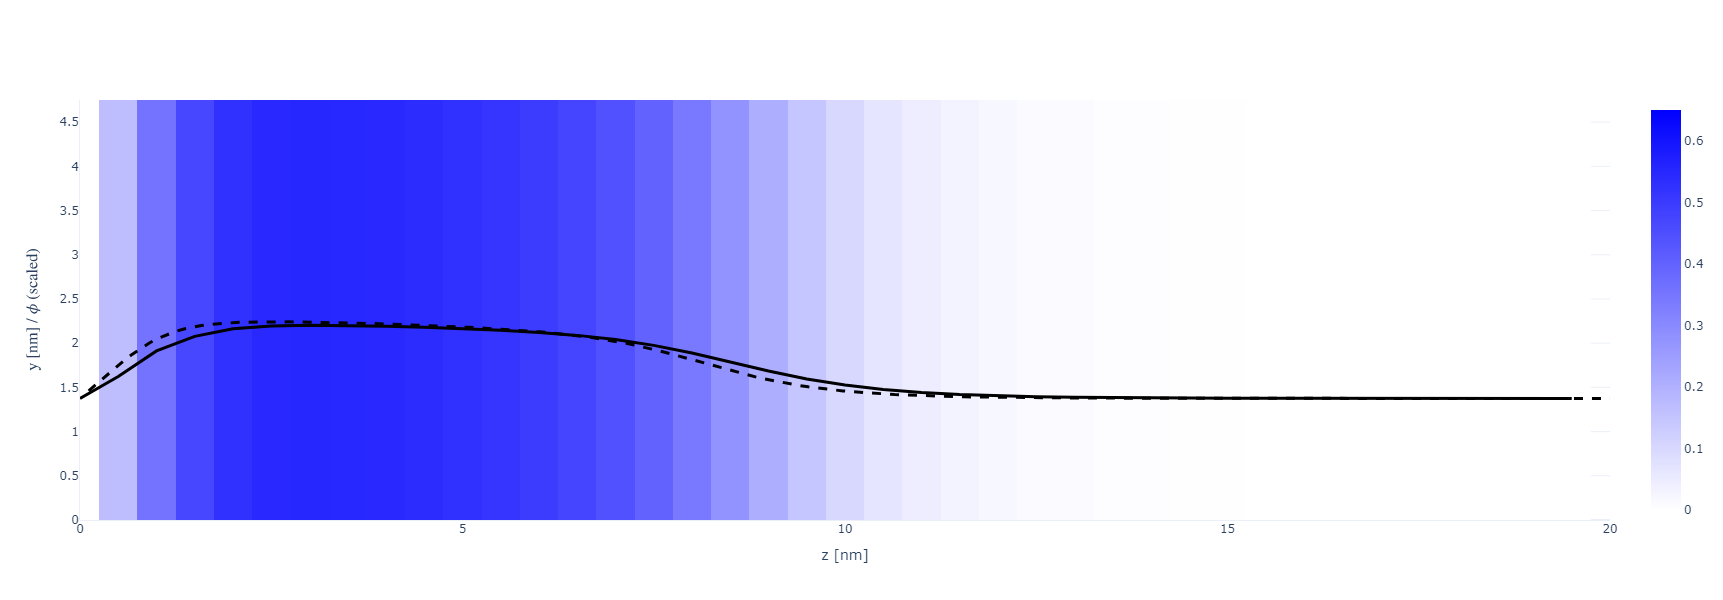

In [143]:
X, Y, Z = np.array(phAr.iloc[:,0]), np.array(phAr.iloc[:,1]), np.array(phAr.iloc[:,2])
vol = np.array(phAr.iloc[:,3])

Lz_max = 20
vol = vol[Z < Lz_max]
X = X[Z < Lz_max]
Y = Y[Z < Lz_max]
Z = Z[Z < Lz_max]

Nz_new = int(len(Z)/Nx/Ny)
x = [X[i*Ny*Nz_new] for i in range(Nx)]
y = [Y[j*Nz_new]    for j in range(Ny)]
z = [Z[k]           for k in range(Nz_new)]

xslice = 10
islice = int(xslice*(x[1]-x[0]))
vol = np.array([vol[(islice*Ny+j)*Nz_new+k] for j in range(Ny) for k in range(Nz_new)]).reshape(Ny, Nz_new)

import plotly.graph_objects as go
heatmap = go.Heatmap(
            x=z, y=y, z=vol,
            zmin = 0.0, zmax = 0.65,
            colorscale= [(0,'White'),(1,'Blue')]
          )
scatter = go.Scatter(
            x = z,
            y = 1.5*vol[int(Ny/2), :] + max(y)/2-1,
            line = dict(color='black', width=3)
          )

fname = GIT+'ph_a000x075_1D.dat'
df = pd.read_csv(fname, sep="\s+", skiprows=0)
a000x075_1d = pd.DataFrame([df.iloc[:,0], df.iloc[:,1]], index=['z', 'pha']).T

reference = go.Scatter(
                x = a000x075_1d.z,
                y = 1.5*a000x075_1d.pha + max(y)/2-1,
                line = dict(color='black', width=3, dash='dash')
            )

layout = go.Layout( xaxis_range = [0, Lz_max], yaxis_range = [0, y[-1]],
                    yaxis_title = r'$\text{y [nm] /  } \phi\ \text{(scaled)}$', xaxis_title = 'z [nm]',
                    scene_xaxis_showticklabels=True,
                    scene_yaxis_showticklabels=True,
                    scene_zaxis_showticklabels=True,
                    showlegend = False,
                    template='plotly_white', width=900, height=600)
fig = go.Figure(data = [heatmap, scatter, reference], layout = layout)
fig.show()

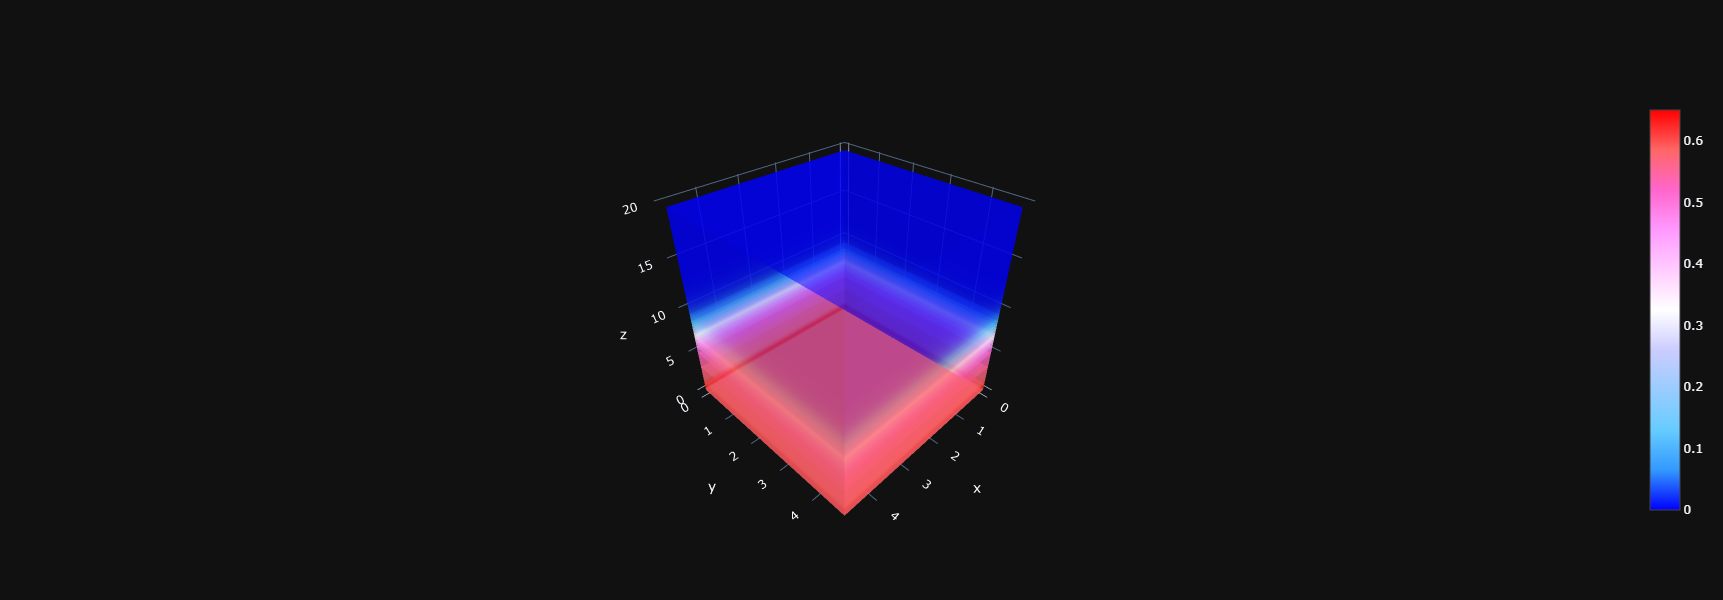

In [117]:
X, Y, Z = np.array(phAr.iloc[:,0]), np.array(phAr.iloc[:,1]), np.array(phAr.iloc[:,2])
vol = np.array(phAr.iloc[:,3])

Lz_max = 20
vol = vol[Z < Lz_max]
X = X[Z < Lz_max]
Y = Y[Z < Lz_max]
Z = Z[Z < Lz_max]

import plotly.graph_objects as go
fig = go.Figure(data=go.Volume(
    x=X, y=Y, z=Z,
    value=vol,
    isomin  =0.0,
    isomax  =0.65,
    opacity =0.6,
    surface_count=15,
    colorscale= 'Picnic' #Blackbody,Bluered,Blues,Cividis,Earth,Electric,Greens,Greys,Hot,Jet,Picnic,Portland,Rainbow,RdBu,Reds,Viridis,YlGnBu,YlOrRd.
    ))
fig.update_layout(scene_xaxis_showticklabels=True,
                  scene_yaxis_showticklabels=True,
                  scene_zaxis_showticklabels=True,
                  template='plotly_dark', width=900, height=600)
fig.show()